# 컴퓨터 비전(VISION)을 위한 전이학습(TRANSFER LEARNING)

## 1. 합성곱 신경망의 미세조정(finetuning)

무작위 초기화 대신, 신경망을 ImageNet 1000 데이터셋 등으로 미리 학습한 신경망으로 초기화 후 학습

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
print(device)

cuda:0


### 데이터 불러오기

- `torchvision`, `torch.utils.data`
- 개미와 벌 각각의 학습/검증 이미지 : 120 / 75
- 일반화하기에는 아주 작은 데이터셋이라서 전이학습을 통해 일반화 성능을 높일 수 있을 것임

In [2]:
data_transforms = {
    'train': transforms.Compose([
        # Data Augmentation
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # Normalization
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # Data Augmentation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # Normalization
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

### 모델 학습하기

- `torch.optim.lr_scheduler`를 사용해 learning rate scheduling 적용

In [3]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    # 학습 시작 시간
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print(f"Epoch {epoch}/{num_epochs}")
        print('-' * 10)

        # 한 epoch마다 train, eval 반복
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                # Inference때 batchnorm, dropout같은거들 고려하려고
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # 데이터를 배치단위로 불러오기
            for inputs, labels in dataloaders[phase]:
                # 데이터 gpu에 올리기
                inputs = inputs.to(device)
                labels = labels.to(device)

                # gradient 0으로 만듦
                optimizer.zero_grad()

                # train mode면 연산을 추적
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    
                    # 가장 높은 확률을 출력한 index 가져오기
                    _, preds = torch.max(outputs, 1)
                    
                    # Loss 계산
                    # 이때, loss가 instance 개수만큼 나오지 않음
                    # criterion = nn.CrossEntropyLoss(reduction='mean')이 defalut라서 평균을 계산하기 때문
                    # criterion = nn.CrossEntropyLoss(reduction='none')으로하면 instance 수만큼 나옴
                    # 즉, batch단위로 loss를 평균내서 계산
                    loss = criterion(outputs, labels)

                    # train mode면 backprop
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                # 평균낸 loss라서, instance 수를 곱해줌
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f"{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # validation accuracy가 가장 좋은 모델의 weight를 deepcopy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f"Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s")
    print(f"Best val Acc: {best_acc:4f}")

    # 가장 나은 모델 가중치를 불러옴
    model.load_state_dict(best_model_wts)
    return model

### 합성곱 신경망 미세조정(finetuning)

- pretrained model의 마지막 fully connected layer를 초기화

In [4]:
model_ft = models.resnet18(pretrained=True)
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [5]:
print(f"Before: {model_ft.fc}")
model_ft.fc = nn.Linear(model_ft.fc.in_features, 2)
print(f"After: {model_ft.fc}")

Before: Linear(in_features=512, out_features=1000, bias=True)
After: Linear(in_features=512, out_features=2, bias=True)


In [6]:
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 learning rate에 0.1을 곱해줌
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

### 학습 및 평가하기

In [7]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 1/25
----------
train Loss: 0.5196 Acc: 0.7172
val Loss: 0.2931 Acc: 0.8758

Epoch 2/25
----------
train Loss: 0.5129 Acc: 0.7992
val Loss: 0.3052 Acc: 0.8889

Epoch 3/25
----------
train Loss: 0.4901 Acc: 0.8156
val Loss: 0.3659 Acc: 0.8497

Epoch 4/25
----------
train Loss: 0.5006 Acc: 0.7664
val Loss: 0.2596 Acc: 0.9085

Epoch 5/25
----------
train Loss: 0.5337 Acc: 0.7951
val Loss: 0.4100 Acc: 0.8693

Epoch 6/25
----------
train Loss: 0.3974 Acc: 0.8607
val Loss: 0.3935 Acc: 0.8627

Epoch 7/25
----------
train Loss: 0.5681 Acc: 0.8033
val Loss: 0.3662 Acc: 0.8889

Epoch 8/25
----------
train Loss: 0.4118 Acc: 0.8566
val Loss: 0.3125 Acc: 0.9281

Epoch 9/25
----------
train Loss: 0.4828 Acc: 0.8402
val Loss: 0.2949 Acc: 0.9216

Epoch 10/25
----------
train Loss: 0.3937 Acc: 0.8770
val Loss: 0.3408 Acc: 0.9085

Epoch 11/25
----------
train Loss: 0.2369 Acc: 0.9139
val Loss: 0.2852 Acc: 0.9216

Epoch 12/25
----------
train Loss: 0.3195 Acc: 0.8770
val Loss: 0.3165 Acc: 0.9150

E

### 모델 예측값 시각화하기

In [9]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title:
        plt.title(title)

        
def visualize_model(model, num_images=4):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

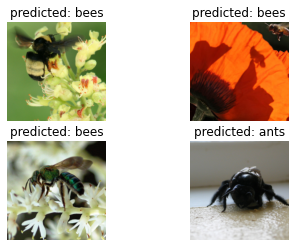

In [10]:
visualize_model(model_ft)

## 2. 고정된 특징 추출기로써의 합성곱 신경망

- 마지막 분류층을 제외한 신경망의 모든 부분에서, `backward()` 호출 시 gradient가 계산되지 않도록 함
    - `requires_grad = False`

In [11]:
resnet_extr = torchvision.models.resnet18(pretrained=True)

# resnet18의 모든 layer의 gradient 계산 X
for param in resnet_extr.parameters():
    param.requires_grad = False

# 마지막 fully connected layer만 초기화
resnet_extr.fc = nn.Linear(resnet_extr.fc.in_features, 2)
resnet_extr = resnet_extr.to(device)
print(resnet_extr.fc.weight.requires_grad)

True


In [12]:
criterion = nn.CrossEntropyLoss()

# 마지막 분류층의 매개변수들만 optimize
optimizer_extr = optim.SGD(resnet_extr.fc.parameters(), lr=0.001, momentum=0.9)

# 7 에폭마다 learning rate에 0.1을 곱해줌
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_extr, step_size=7, gamma=0.1)

### 학습 및 평가하기

In [13]:
resnet_extractor = train_model(resnet_extr, criterion, optimizer_extr,
                         exp_lr_scheduler, num_epochs=25)

Epoch 1/25
----------
train Loss: 0.9432 Acc: 0.5615
val Loss: 0.2791 Acc: 0.8824

Epoch 2/25
----------
train Loss: 0.4580 Acc: 0.8033
val Loss: 0.2245 Acc: 0.9085

Epoch 3/25
----------
train Loss: 0.4582 Acc: 0.8115
val Loss: 0.1932 Acc: 0.9281

Epoch 4/25
----------
train Loss: 0.5021 Acc: 0.7869
val Loss: 0.3477 Acc: 0.8562

Epoch 5/25
----------
train Loss: 0.6181 Acc: 0.7377
val Loss: 0.3638 Acc: 0.8693

Epoch 6/25
----------
train Loss: 0.4414 Acc: 0.8197
val Loss: 0.2043 Acc: 0.9346

Epoch 7/25
----------
train Loss: 0.4514 Acc: 0.7992
val Loss: 0.1887 Acc: 0.9346

Epoch 8/25
----------
train Loss: 0.2752 Acc: 0.9057
val Loss: 0.1968 Acc: 0.9346

Epoch 9/25
----------
train Loss: 0.3031 Acc: 0.8484
val Loss: 0.1834 Acc: 0.9412

Epoch 10/25
----------
train Loss: 0.3758 Acc: 0.8402
val Loss: 0.1845 Acc: 0.9477

Epoch 11/25
----------
train Loss: 0.2778 Acc: 0.8975
val Loss: 0.1803 Acc: 0.9412

Epoch 12/25
----------
train Loss: 0.3495 Acc: 0.8484
val Loss: 0.1873 Acc: 0.9477

E

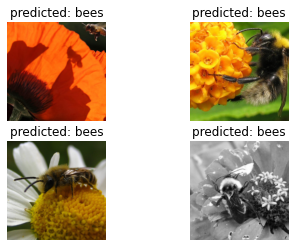

In [14]:
visualize_model(resnet_extractor)